In [ ]:
# Code for the Book: International Stock Picking A.I. INVESTOR: A Guide to Build.
# Website: ai-investor.net
# Code needs am "All-In-One" subscription from the (presumably) nice people at https://eodhistoricaldata.com/. 
# Check the book text to see if they have changed their service since mid-2021.

# Damon Lee 2021

# Feel free to fork this code for others to see what can be done with it.

# Neural Networks

In [1]:
import pandas as pd
import numpy as np
from numpy import random
from matplotlib import pyplot as plt

# Set the plotting DPI settings to be a bit higher.
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [7.0, 4.5]
plt.rcParams['figure.dpi'] = 150

In [2]:
def oneOrMinusOne(x):
    '''
    Just using this function to turn regression predictors into classification predictors in this notebook.
    Problems we will use on:
    Bankruptcy: -1(bankrupt), 1(not bankrupt)
    Tech Company Prediction: -1(Not a tech company), 1 (Tech company)
    '''
    if x > 0:
        return 1
    else:
        return -1

## Section Flow
#### First Bit - Get NN up and Running
* 7 neuron Artificial Neural Net, feedworward only, with full algebra
* See it attempting to predict bankruptcy with random weights
* See it predicting bankruptcy when the weights are good
* See backpropagation with full algebra for getting better weights iteratively
* See simplified algebra with matrix maths for neural net
* See backpropagation learning on bankruptcy prediction, with increasing accuracy over time

#### Second Bit - Get NN working on predicting Tech or not, use Keras
* Neural network into an object with prediction and backpropagation as member functions
* Tech company or not problem!, larger network with more features, we can use our neural net on this problem
* See learning curves for the neural net
* Compare the simple neural net created here with Keras
* see Keras performance with more neural net  layers, it is easier and faster than our neural net.

We'll use Keras going forward.

#### Afterwards -> Should have conveyed enough knowledge to use on the stock prediction problem (next section)

# Single Neuron & Activation Functions

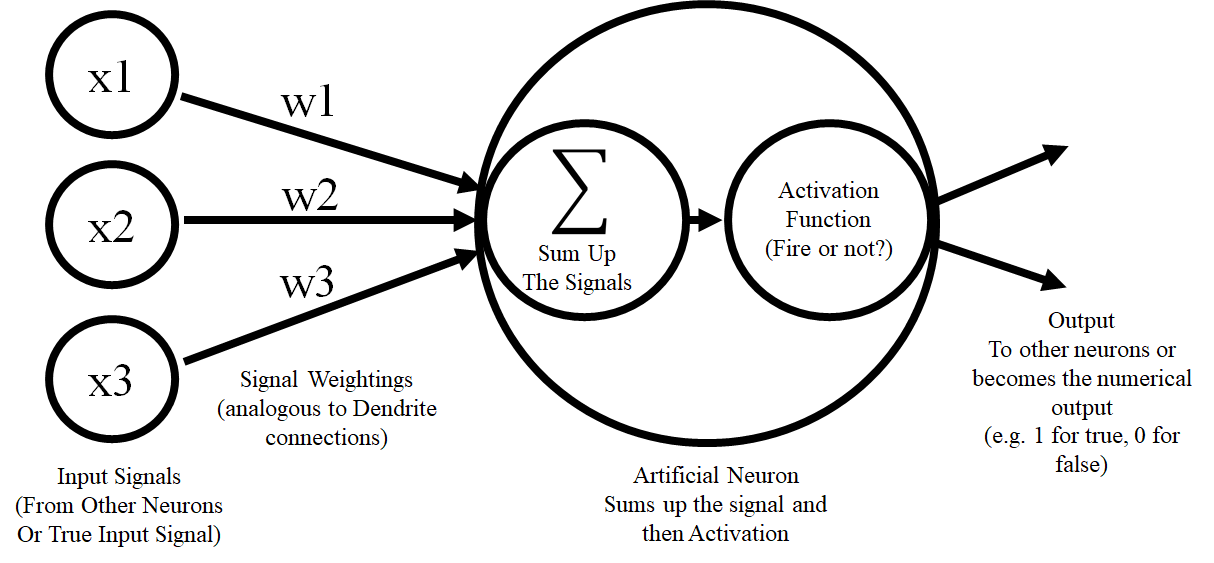

In [3]:
# Example Activation Functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def sigmoidGrad(x):
    return (1 - sigmoid(x)) * sigmoid(x)

def tanh(x):
    return np.tanh(x)
def tanhGrad(x):
    return 1-np.tanh(x) * np.tanh(x)

def relu(x):
    answer = x.copy()
    answer[x>0]=x[x>0]
    answer[x<=0]=0
    return answer
def reluGrad(x):
    answer = x.copy()
    answer[x>0]=1
    answer[x<=0]=0
    return answer

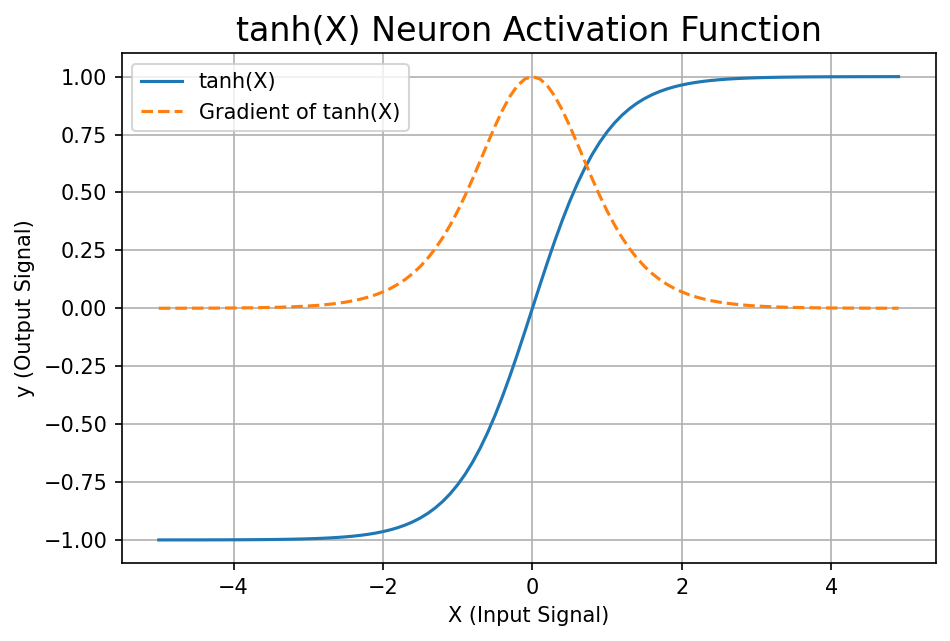

In [4]:
# plot Tanh
x = np.arange(-5,5,0.1)
plt.plot(x,tanh(x))
plt.plot(x,tanhGrad(x),'--')
plt.grid()
plt.legend(['tanh(X)', 'Gradient of tanh(X)'])
plt.xlabel('X (Input Signal)')
plt.ylabel('y (Output Signal)')
plt.title('tanh(X) Neuron Activation Function',fontsize=16);

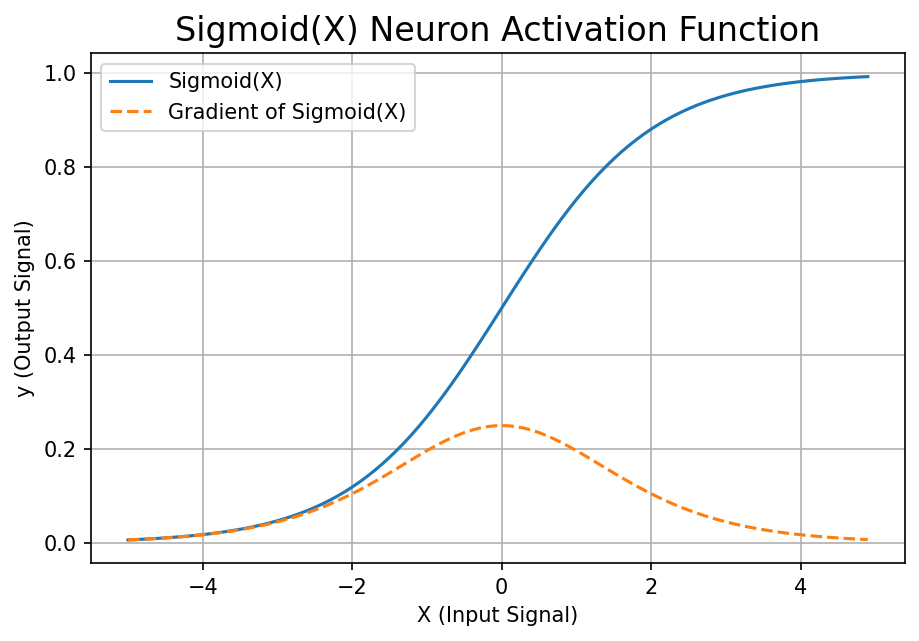

In [5]:
# plot Sigmoid
x = np.arange(-5,5,0.1)
plt.plot(x,sigmoid(x))
plt.plot(x,sigmoidGrad(x),'--')
plt.grid()
plt.legend(['Sigmoid(X)', 'Gradient of Sigmoid(X)'])
plt.xlabel('X (Input Signal)')
plt.ylabel('y (Output Signal)')
plt.title('Sigmoid(X) Neuron Activation Function',fontsize=16);

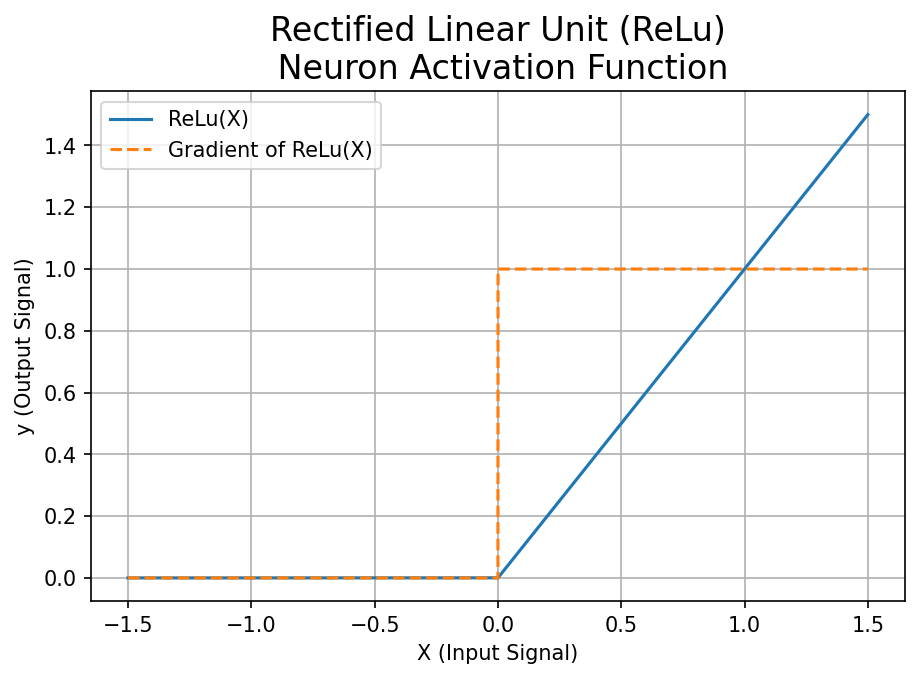

In [6]:
# plot ReLu
x = np.arange(-1.5,1.5,1e-4)
plt.plot(x,relu(x))
plt.plot(x,reluGrad(x),'--')
plt.grid()
plt.legend(['ReLu(X)', 'Gradient of ReLu(X)'])
plt.xlabel('X (Input Signal)')
plt.ylabel('y (Output Signal)')
plt.title('Rectified Linear Unit (ReLu)\n Neuron Activation Function',fontsize=16);

In [7]:
# Example just using a single neuron.
# Different inputs, different outputs.

x1, x2, x3 = 0.46, 0.67, 0.92 # Input Values
#x1, x2, x3 = 0.01, 0.01, 0.01 # Input Values

neuronWeight1, neuronWeight2, neuronWeight3 = 0.3, 0.5, 0.8
neuronSumSignalIn = neuronWeight1 * x1 \
                    + neuronWeight2 * x2 \
                    + neuronWeight3 * x3
neuronSignalOut =  tanh(neuronSumSignalIn)

print('Input signals to neuron are:\t', [x1, x2, x3])
print('Output signal from neuron is:\t',neuronSignalOut)

Input signals to neuron are:	 [0.46, 0.67, 0.92]
Output signal from neuron is:	 0.8363792705576482


# Predict Bankruptcy - Very Basic 7 Neuron Network

In [8]:
# Read in X and y data.
stocksRatiosList=pd.read_csv('bankruptStocks.csv', index_col=0)
bankruptList=pd.read_csv('bankruptStocksTarget.csv', index_col=0)
bankruptList.replace(0,-1, inplace=True)

#bankruptList.replace(1,-1, inplace=True) # For 1=Bankrupt, -1=Non-bankrupt
#bankruptList.replace(0,1, inplace=True)

# Optional, scramble the learning data order
#stocksRatiosList=stocksRatiosList.sample(frac=1.0) 

# Convert to Numpy Array format
bankruptList=bankruptList.loc[stocksRatiosList.index].to_numpy()
stocksRatiosList=stocksRatiosList.to_numpy()

In [9]:
stocksRatiosList[:5] # See first 5 rows of learning data

array([[-0.34119943,  0.        , -0.04595458, -0.00594707],
       [ 0.09938666, -0.45900613, -0.07059707,  0.11578212],
       [ 0.085321  , -0.23509989, -0.06415694, -0.0390527 ],
       [ 0.01380292,  0.03967232, -0.03543753,  1.22147581],
       [-0.07046255, -0.87815723, -0.03884394,  0.37008141]])

In [10]:
bankruptList[:5] # See first 5 rows of the target results (Bankrupt or Non-bankrupt)

array([[-1],
       [-1],
       [-1],
       [-1],
       [-1]], dtype=int64)

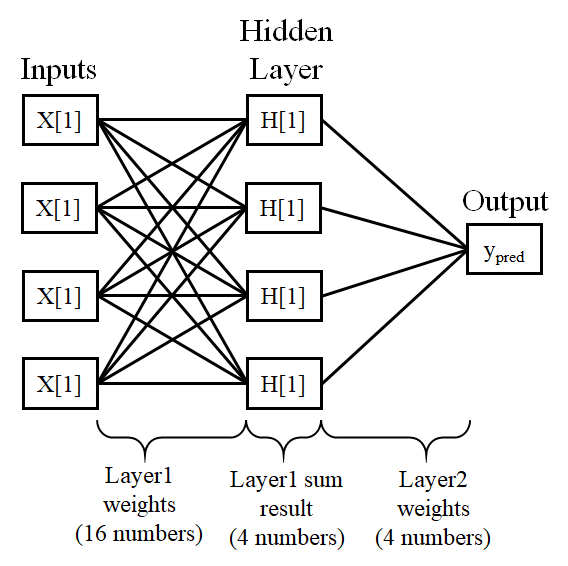

In [11]:
# Connection weights of 1, -1
w1 = np.array([[1, -1, 1, -1],
               [-1, 1, -1, 1],
               [1, -1, 1, -1],
               [-1, 1, -1, 1]])

w2 = np.array([1, -1, 1, -1])

# Random number connection weights
#w1 = np.random.rand(4,4)*2-1
#w2 = np.random.rand(4)*2-1

In [12]:
def runNN(x):
    '''
    Simple 9 neuron neural network.
    
    Input X, a matrix of 4 numbers.
    return the prediction y
    '''
    N=np.zeros(4)
    N[0] = tanh(w1[0,0] * x[0] + w1[1,0] * x[1] + w1[2,0] * x[2] + w1[3,0] * x[3])
    N[1] = tanh(w1[0,1] * x[0] + w1[1,1] * x[1] + w1[2,1] * x[2] + w1[3,1] * x[3])
    N[2] = tanh(w1[0,2] * x[0] + w1[1,2] * x[1] + w1[2,2] * x[2] + w1[3,2] * x[3])
    N[3] = tanh(w1[0,3] * x[0] + w1[1,3] * x[1] + w1[2,3] * x[2] + w1[3,3] * x[3])

    y_pred = tanh(w2[0] * N[0] + w2[1] * N[1] + w2[2] * N[2] + w2[3] * N[3])
    return y_pred

In [13]:
i = 1 # try stock numbers 0 to 49
print('Input neural net data is: \t', stocksRatiosList[i])
print('The resulting output is: \t', runNN(stocksRatiosList[i]))

Input neural net data is: 	 [ 0.09938666 -0.45900613 -0.07059707  0.11578212]
The resulting output is: 	 0.890224531936004


In [14]:
def checkPerformance(predictor, stocksRatiosList, bankruptList):
    '''
    Runs a forward pass for our neural network predictor
    
    Makes the answer 1 or -1 from outputs that are decimal numbers
    to predict bankrupt or non-bankrupt
    
    Plots the prediction results with the real answers
    '''
    predictions = []
    for i in range(stocksRatiosList.shape[0]):
        predictions.append(oneOrMinusOne(predictor(stocksRatiosList[i])))
        
    plotBankruptcyPredictions(np.array(predictions), 
                              bankruptList.reshape(1,-1)[0])
    
    
def plotBankruptcyPredictions(predictionsArray, targetsArray):
    '''
    Given two arrays containing -1s and 1s, plots in black and white
    one array on top of the other, -1 as white, 1 as black.
    '''
    plt.figure(figsize=(10,10), dpi=100)
    plt.imshow([predictionsArray, targetsArray], cmap='gnuplot2', )
    plt.title('Super simple Neural Net Bankruptcy Prediction'+\
              '\n (Using Training Data Only)')
    
    #plt.ylabel('TrainingData(1)\n Prediction (0)', rotation=0)
    plt.yticks(ticks=[0, 1],labels=['Prediction','Actual'])
    plt.xlabel('Company Stock (50 companies total)')

    import matplotlib.patches as mpatches
    black_patch = mpatches.Patch(facecolor='black', 
                                 edgecolor='black', 
                                 label='Bankrupt')
    
    white_patch = mpatches.Patch(facecolor='white', 
                                 edgecolor='black', 
                                 label='Non Bankrupt')

    plt.legend(handles=[black_patch, white_patch], bbox_to_anchor=(1,1), loc=2)

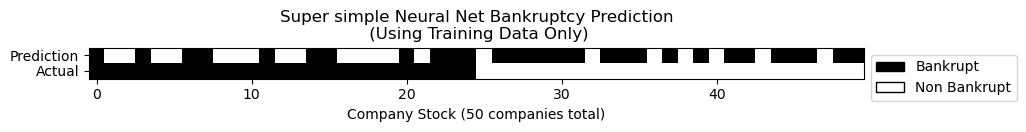

In [15]:
# Try the neural network with the present set 
# of w1 and w2 neural network weights
checkPerformance(runNN, stocksRatiosList, bankruptList)

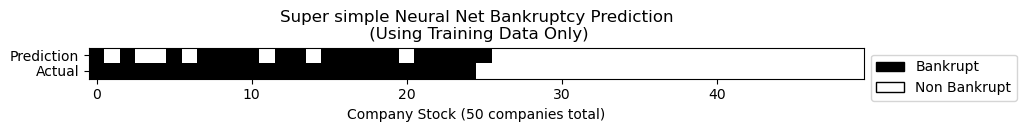

In [16]:
# Good set of weights, found earlier.
w1 = np.array([[-1.12814054,  1.0484946,  -1.633827,   -0.09792053],
               [ 0.47087402, -0.81399775,  1.05598582, -1.82289679],
               [-2.24484692,  2.96787754, -0.90493288,  3.74773478],
               [-0.26316545,  1.33937166, -2.81183966,  7.51556155]])
w2 = np.array([-2.48549821,  0.81311468,  2.06648028,  1.66142687])

checkPerformance(runNN, stocksRatiosList, bankruptList)

# Predict Bankruptcy - BackPropagation To Get The Neural Network Weights

In [17]:
def backPropNN(x, y, w1, w2):
    '''
    Input x, y
    update weights with backprop
    '''
    
    #First a forward pass
    N=np.zeros(4)
    N[0] = tanh(w1[0,0] * x[0] + w1[1,0] * x[1] + w1[2,0] * x[2] + w1[3,0] * x[3])
    N[1] = tanh(w1[0,1] * x[0] + w1[1,1] * x[1] + w1[2,1] * x[2] + w1[3,1] * x[3])
    N[2] = tanh(w1[0,2] * x[0] + w1[1,2] * x[1] + w1[2,2] * x[2] + w1[3,2] * x[3])
    N[3] = tanh(w1[0,3] * x[0] + w1[1,3] * x[1] + w1[2,3] * x[2] + w1[3,3] * x[3])

    output = tanh(w2[0] * N[0] + w2[1] * N[1] + w2[2] * N[2] + w2[3] * N[3])
    
    
    loss2 = 2*(y - output) * tanhGrad(output)
    w2_correction = N * loss2    
    
    loss1 = loss2 * w2 * tanhGrad(N)
    w1_correction = np.multiply(x.reshape(-1,1), loss1)
    
    w1 = w1 + 0.01 * w1_correction
    w2 = w2 + 0.01 * w2_correction
    return w1, w2

In [18]:
w1 = np.random.rand(4,4)*2-1
w1

array([[-0.06989941, -0.57330068, -0.82218462, -0.63048294],
       [-0.91930151,  0.58835658,  0.49580541,  0.40157776],
       [-0.5654644 ,  0.20955671, -0.68104897,  0.77373297],
       [-0.7102391 ,  0.5050693 ,  0.99555564,  0.05840944]])

In [19]:
for i in range(0, 50):
    w1, w2 = backPropNN(stocksRatiosList[i], bankruptList[i], w1, w2)

In [20]:
w1

array([[-0.19817216, -0.53115326, -0.71976169, -0.54817335],
       [-0.68128221,  0.51708286,  0.30035039,  0.24312841],
       [-0.55676341,  0.20733685, -0.69332767,  0.77034612],
       [-0.65687494,  0.48188954,  0.94825419, -0.01913762]])

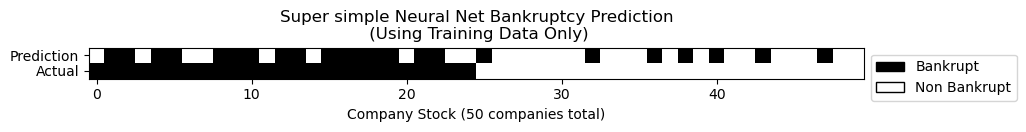

In [21]:
checkPerformance(runNN, stocksRatiosList, bankruptList)

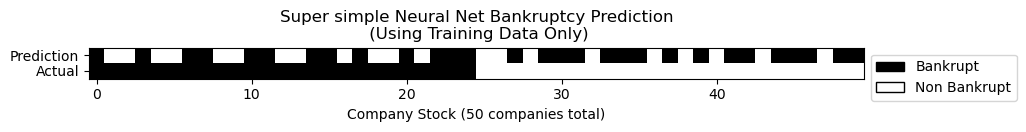

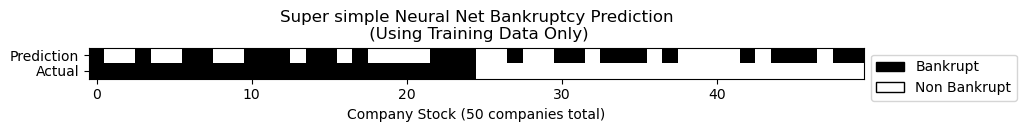

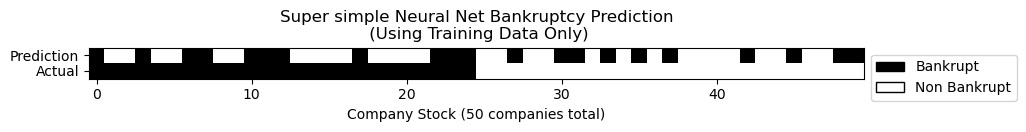

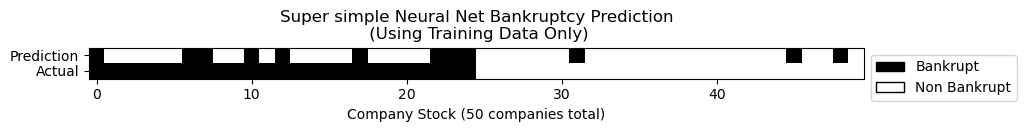

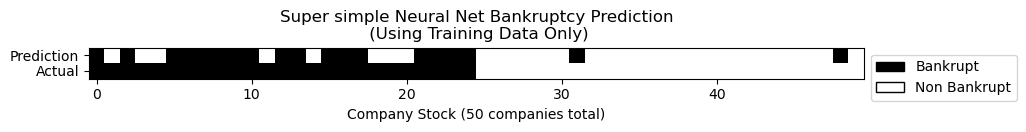

In [22]:
# Iterate through many times,
# Start from a bad neural net:

w1 = np.array([[1, -1, 1, -1],
               [-1, 1, -1, 1],
               [1, -1, 1, -1],
               [-1, 1, -1, 1]]) # obviously bad Neural Net

w2 = np.array([1, -1, 1, -1])

# Now do the backpropagation
for j in range(1025): # Many times
    for i in range(0, 50): # For all of our companies, one at a time.
        w1, w2 = backPropNN(stocksRatiosList[i], bankruptList[i], w1, w2)
    
    if j in [1, 4, 8, 16, 1024]: # Plot the results every so often
        checkPerformance(runNN, stocksRatiosList, bankruptList)

# Predict Bankruptcy -  Put NN in an object so it stores its values
# Also Use Matrix Algebra To Simplify The Maths

In [8]:
class NeuralNet:
    def __init__(self, X, y):
        self.inData=X
        self.outTarget=y
        
        #len(X) input neurons, first layer neurons varying in number
        self.l1_weights=np.random.rand(len(X), 4) * 2 - 1 
        self.l2_weights=np.random.rand(1,4) * 2 - 1
        self.l1_bias=np.random.rand(1,4) * 2 - 1
        self.prediction=np.zeros(self.outTarget.shape)
        
    def feedForward(self, X):
        self.layer1 = tanh(np.dot(X, self.l1_weights))#\
        # + self.l1_bias) # optional, use the bias term
        self.output = tanh(np.dot(self.layer1, self.l2_weights.T))
        return self.output
    
    def backPropInstance(self, X, y):
        self.output = self.feedForward(X)
        
        self.d_l2_weights = \
        np.multiply(self.layer1.T, 
                    (2*(y - self.output) * tanhGrad(self.output)))
        
        self.d_l1_weights = \
        np.multiply(X.reshape(-1,1), # replace line with previous layer if adding more layers.
                    (np.dot(2*(y - self.output) * tanhGrad(self.output), 
                            self.l2_weights) * tanhGrad(self.layer1)))
        
        self.d_l1_bias = (2*(y - self.output) * tanhGrad(self.output))
        
        self.l1_weights += 0.01 * self.d_l1_weights
        self.l2_weights += 0.01 * self.d_l2_weights
        self.l1_bias += 0.01 * self.d_l1_bias
        pass
        
    def seeWeights(self):
        #print(self.l1_weights)
        #print(self.l2_weights)
        #print(self.l1_bias)
        return [self.l1_weights, self.l2_weights[0], self.l1_bias[0]]

In [24]:
bankruptcyPredNN = NeuralNet(stocksRatiosList[0], bankruptList[0])

for j in range(500):
    for i in range(stocksRatiosList.shape[0]):
        bankruptcyPredNN.backPropInstance(stocksRatiosList[i], bankruptList[i])
        
predictions = []
for i in range(stocksRatiosList.shape[0]):
    predictions.append(oneOrMinusOne(bankruptcyPredNN.feedForward(stocksRatiosList[i])))
    
from sklearn.metrics import accuracy_score
accuracy_score(predictions, bankruptList)

0.78

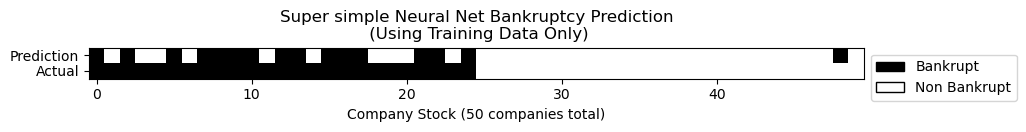

In [25]:
plotBankruptcyPredictions(np.array(predictions), bankruptList.reshape(1,-1)[0])

# Predict Tech Or Not 

In [9]:
X=pd.read_csv('techNoTech_X.csv', index_col=0)
y=pd.read_csv('techNoTech_y.csv', index_col=0)

X=X.sample(X.shape[0])#[['Selling, General & Administrative/Rev.', 'Research & Development/Rev.', 'Operating Income (Loss)/Rev.', 'Operating Expenses/Rev.']]
y=y.loc[X.index]

y.replace(False, -1, inplace=True)
y.replace(True, 1, inplace=True)
X=X.to_numpy()
y=y.to_numpy()

In [27]:
X.shape

(7304, 8)

In [28]:
class NeuralNet:
    def __init__(self, X, y):
        self.inData=X
        self.outTarget=y
        
        #len(X) input neurons, first layer neurons varying in number
        self.l1_weights=np.random.rand(len(X), 6)
        self.l2_weights=np.random.rand(1,6)
        self.prediction=np.zeros(self.outTarget.shape)
        
    def feedForward(self, X):
        self.layer1 = tanh(np.dot(X, self.l1_weights))#\
        # + self.l1_bias) # optional, use the bias term
        self.output = tanh(np.dot(self.layer1, self.l2_weights.T))
        return self.output
    
    def backPropInstance(self, X, y):
        self.output = self.feedForward(X)
        
        self.d_l2_weights = \
        np.multiply(self.layer1.T, 
                    (2*(y - self.output) * tanhGrad(self.output)))
        
        self.d_l1_weights = \
        np.multiply(X.reshape(-1,1),  
                    (np.dot(2*(y - self.output) * tanhGrad(self.output), 
                            self.l2_weights) * tanhGrad(self.layer1)))
        
        self.l1_weights += 0.01 * self.d_l1_weights
        self.l2_weights += 0.01 * self.d_l2_weights

## Make Learning Curves

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=1000, 
                                                    random_state=42)

In [56]:
from sklearn.metrics import accuracy_score

# Store training and testing errors in lists.
trainErr, testErr = [], []

# Make learning curves. Varying the quantity of training data.
# ~6000 rows, increase training data in steps of 50.
for i in np.arange(50,6000,50):
    
    # Make the neural net
    MSE_test, MSE_train = 0, 0
    nn = NeuralNet(X[0], y[0]) # new network weights each time

    # Train the neural net
    for k in range(0, 2): # Training epochs
        for ii in range(0, i):
            nn.backPropInstance(X_train[ii], y_train[ii])
    
    # Record neural net performance for quantity of data trained on
    trainPreds, testPreds = [], []
    
    # Error vs. training data
    for ii in range(0, i):
        trainPreds.append(oneOrMinusOne(nn.feedForward(X_train[ii])))
        
    # Error vs. testing data
    for ii in range(0, 1000):
        testPreds.append(oneOrMinusOne(nn.feedForward(X_test[ii])))
    
    trainErr.append(accuracy_score(trainPreds, 
                                   list(y_train[:i].reshape(1,-1)[0])))
    testErr.append(accuracy_score(testPreds, 
                                  list(y_test.reshape(1,-1)[0])))

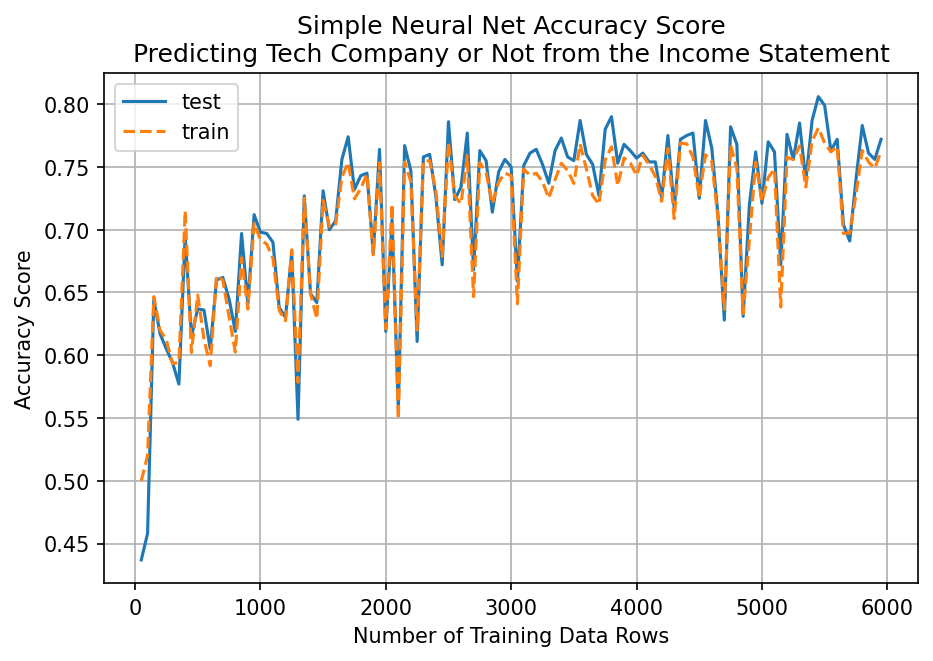

In [65]:
from matplotlib import pyplot as plt
plt.plot(np.arange(50,6000,50), testErr)
plt.plot(np.arange(50,6000,50), trainErr,'--')
plt.legend(['test', 'train']);
plt.grid()
plt.ylabel('Accuracy Score');
plt.xlabel('Number of Training Data Rows');
plt.title('Simple Neural Net Accuracy Score\n'+\
          'Predicting Tech Company or Not from the Income Statement');

In [33]:
from sklearn.metrics import accuracy_score

trainErr, testErr = [], []
for i in np.arange(50,6000,50):
    MSE_test, MSE_train = 0, 0
    nn = NeuralNet(X[0], y[0]) # new weights

    for k in range(0, 2): # epochs
        for ii in range(0, i):
            nn.backPropInstance(X_train[ii], y_train[ii])
            
    trainPreds, testPreds = [], []
    
    for ii in range(0, i):
        MSE_train += (nn.feedForward(X_train[ii]) - y_train[ii]) ** 2
    MSE_train = MSE_train/(i)
    
    for ii in range(0, 1000):
        MSE_test += (nn.feedForward(X_test[ii]) - y_test[ii]) ** 2
    MSE_test = MSE_test/1000
    
    trainErr.append(MSE_train)
    testErr.append(MSE_test)

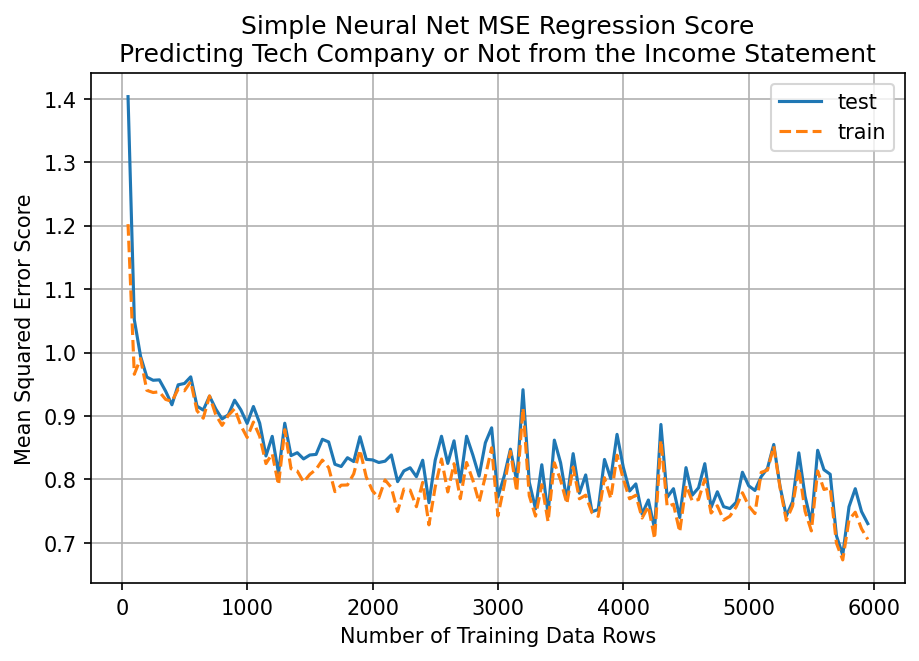

In [34]:
from matplotlib import pyplot as plt
plt.plot(np.arange(50,6000,50), testErr)
plt.plot(np.arange(50,6000,50), trainErr,'--')
plt.legend(['test', 'train']);
plt.grid()
plt.ylabel('Mean Squared Error Score');
plt.xlabel('Number of Training Data Rows');
plt.title('Simple Neural Net MSE Regression Score\n'+\
          'Predicting Tech Company or Not from the Income Statement');

In [556]:
real, pred = [], []
for i in range(0,1000):
    real.append(y_test[i])
    pred.append(oneOrMinusOne(nn.feedForward(X_test[i])))
    
from sklearn.metrics import confusion_matrix
confusion_matrix(real, pred)

array([[404, 122],
       [110, 364]], dtype=int64)

# Predict Tech Or Not - Use Keras Library To Make The NN

In [11]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__,'\n',keras.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

model = keras.models.Sequential()
#model.add(keras.layers.Flatten(input_shape=[18]))
model.add(keras.layers.Dense(6, activation = 'tanh', input_shape = (8,)))
#model.add(keras.layers.Dense(6, activation='tanh'))
#model.add(keras.layers.Dense(6, activation='tanh'))
model.add(keras.layers.Dense(1, activation='tanh'))
model.summary()

optimizer = keras.optimizers.Adam(learning_rate = 0.001, 
                                  beta_1 = 0.9, 
                                  beta_2 = 0.999, 
                                  amsgrad = False)

model.compile(loss='mean_squared_error', optimizer=optimizer)

2.0.0 
 2.2.4-tf
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6108975831944130725
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4953931776
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3997478847293089636
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:02:00.0, compute capability: 7.5"
]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 54        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(X_train, y_train, batch_size = 512, epochs = 100, validation_split = 0.05)

Train on 5988 samples, validate on 316 samples
Epoch 1/100
5988/5988 [==============================] - 1s 213us/sample - loss: 1.1321 - val_loss: 1.0836
Epoch 2/100
5988/5988 [==============================] - 0s 7us/sample - loss: 1.1037 - val_loss: 1.0612
Epoch 3/100
5988/5988 [==============================] - 0s 7us/sample - loss: 1.0777 - val_loss: 1.0430
Epoch 4/100
5988/5988 [==============================] - 0s 7us/sample - loss: 1.0553 - val_loss: 1.0275
Epoch 5/100
5988/5988 [==============================] - 0s 7us/sample - loss: 1.0352 - val_loss: 1.0148
Epoch 6/100
5988/5988 [==============================] - 0s 7us/sample - loss: 1.0185 - val_loss: 1.0044
Epoch 7/100
5988/5988 [==============================] - 0s 7us/sample - loss: 1.0038 - val_loss: 0.9958
Epoch 8/100
5988/5988 [==============================] - 0s 7us/sample - loss: 0.9920 - val_loss: 0.9885
Epoch 9/100
5988/5988 [==============================] - 0s 7us/sample - loss: 0.9817 - val_loss: 0.9822
Epoch 

Epoch 77/100
5988/5988 [==============================] - 0s 6us/sample - loss: 0.7830 - val_loss: 0.8144
Epoch 78/100
5988/5988 [==============================] - 0s 6us/sample - loss: 0.7809 - val_loss: 0.8127
Epoch 79/100
5988/5988 [==============================] - 0s 6us/sample - loss: 0.7787 - val_loss: 0.8113
Epoch 80/100
5988/5988 [==============================] - 0s 7us/sample - loss: 0.7766 - val_loss: 0.8096
Epoch 81/100
5988/5988 [==============================] - 0s 6us/sample - loss: 0.7746 - val_loss: 0.8080
Epoch 82/100
5988/5988 [==============================] - 0s 6us/sample - loss: 0.7727 - val_loss: 0.8050
Epoch 83/100
5988/5988 [==============================] - 0s 6us/sample - loss: 0.7704 - val_loss: 0.8046
Epoch 84/100
5988/5988 [==============================] - 0s 6us/sample - loss: 0.7687 - val_loss: 0.8028
Epoch 85/100
5988/5988 [==============================] - 0s 6us/sample - loss: 0.7666 - val_loss: 0.8008
Epoch 86/100
5988/5988 [======================

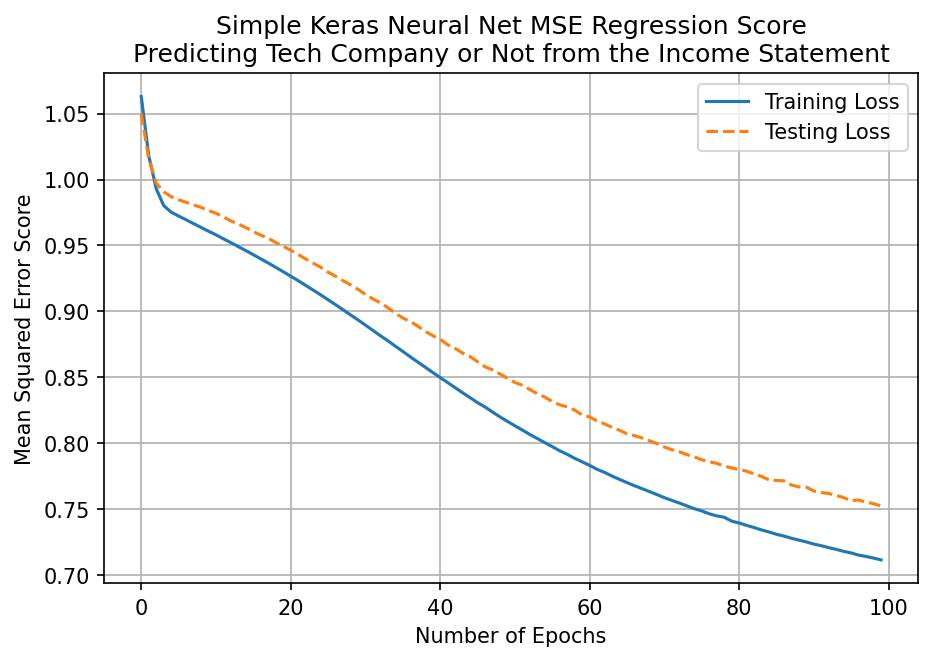

In [51]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'],'--')
plt.legend(['Training Loss','Testing Loss'])
plt.grid()
plt.ylabel('Mean Squared Error Score');
plt.xlabel('Number of Epochs');
plt.title('Simple Keras Neural Net MSE Regression Score\n'+\
          'Predicting Tech Company or Not from the Income Statement');

# Predict Tech Or Not WIth A Larger Keras NN

In [39]:
model = keras.models.Sequential()
#model.add(keras.layers.Flatten(input_shape=[18]))
model.add(keras.layers.Dense(7, activation = 'tanh', input_shape = (8,)))
model.add(keras.layers.Dense(7, activation='tanh'))
model.add(keras.layers.Dense(7, activation='tanh'))
model.add(keras.layers.Dense(1, activation='tanh'))
model.summary()

optimizer = keras.optimizers.Adam(learning_rate = 0.001, 
                                  beta_1 = 0.9, 
                                  beta_2 = 0.999, 
                                  amsgrad = False)

model.compile(loss='mean_squared_error', optimizer=optimizer)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 7)                 63        
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 8         
Total params: 183
Trainable params: 183
Non-trainable params: 0
_________________________________________________________________


Train on 5988 samples, validate on 316 samples
Epoch 1/100
5988/5988 [==============================] - 1s 94us/sample - loss: 1.1318 - val_loss: 1.0395
Epoch 2/100
5988/5988 [==============================] - 0s 8us/sample - loss: 1.0150 - val_loss: 0.9803
Epoch 3/100
5988/5988 [==============================] - 0s 8us/sample - loss: 0.9693 - val_loss: 0.9671
Epoch 4/100
5988/5988 [==============================] - 0s 7us/sample - loss: 0.9468 - val_loss: 0.9559
Epoch 5/100
5988/5988 [==============================] - 0s 7us/sample - loss: 0.9307 - val_loss: 0.9485
Epoch 6/100
5988/5988 [==============================] - 0s 7us/sample - loss: 0.9187 - val_loss: 0.9443
Epoch 7/100
5988/5988 [==============================] - 0s 8us/sample - loss: 0.9089 - val_loss: 0.9397
Epoch 8/100
5988/5988 [==============================] - 0s 8us/sample - loss: 0.8989 - val_loss: 0.9344
Epoch 9/100
5988/5988 [==============================] - 0s 8us/sample - loss: 0.8881 - val_loss: 0.9265
Epoch 1

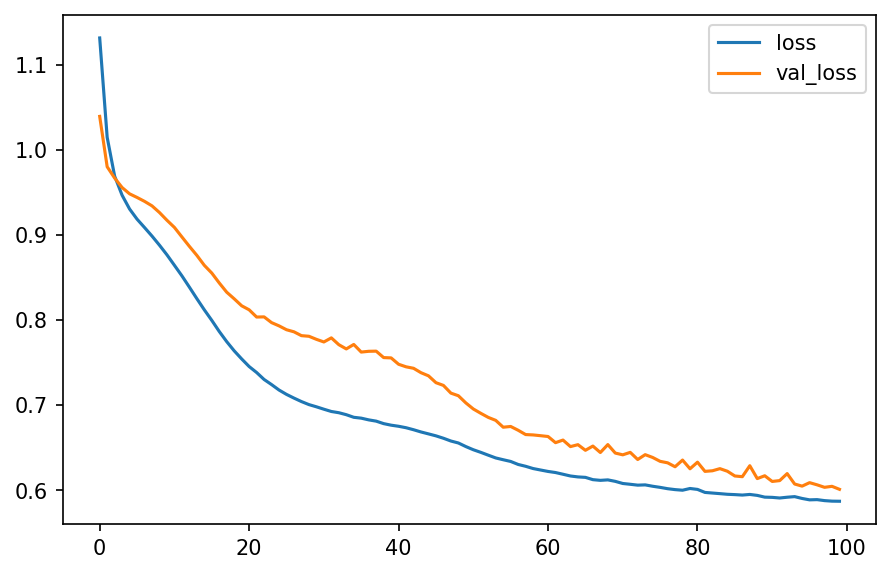

In [40]:
history = model.fit(X_train, y_train, batch_size = 512, epochs = 100, validation_split = 0.05)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])

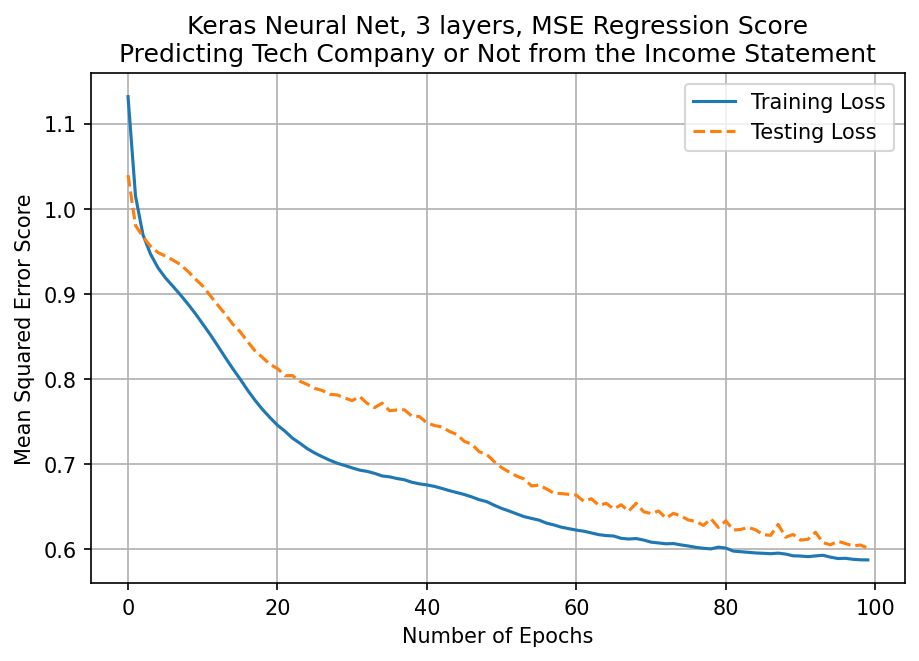

In [42]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'],'--')
plt.legend(['Training Loss','Testing Loss'])
plt.grid()
plt.ylabel('Mean Squared Error Score');
plt.xlabel('Number of Epochs');
plt.title('Keras Neural Net, 3 layers, MSE Regression Score\n'+\
          'Predicting Tech Company or Not from the Income Statement');

# Try NN Overfit

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                90        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

5988/5988 [==============================] - 0s 10us/sample - loss: 0.5710 - val_loss: 0.7140
Epoch 61/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5689 - val_loss: 0.7030
Epoch 62/1000
5988/5988 [==============================] - 0s 9us/sample - loss: 0.5684 - val_loss: 0.6953
Epoch 63/1000
5988/5988 [==============================] - 0s 9us/sample - loss: 0.5677 - val_loss: 0.6962
Epoch 64/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5666 - val_loss: 0.7083
Epoch 65/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5719 - val_loss: 0.6901
Epoch 66/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5667 - val_loss: 0.7024
Epoch 67/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5665 - val_loss: 0.7001
Epoch 68/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5646 - val_loss: 0.6887
Epoch 69/1000
5988/5988 [===================

5988/5988 [==============================] - 0s 11us/sample - loss: 0.5460 - val_loss: 0.6832
Epoch 211/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5450 - val_loss: 0.6798
Epoch 212/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5468 - val_loss: 0.6745
Epoch 213/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5475 - val_loss: 0.6808
Epoch 214/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5441 - val_loss: 0.6753
Epoch 215/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5449 - val_loss: 0.6849
Epoch 216/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5470 - val_loss: 0.6773
Epoch 217/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5443 - val_loss: 0.6825
Epoch 218/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5492 - val_loss: 0.6764
Epoch 219/1000
5988/5988 [========

5988/5988 [==============================] - 0s 9us/sample - loss: 0.5310 - val_loss: 0.6720
Epoch 361/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5328 - val_loss: 0.6766
Epoch 362/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5328 - val_loss: 0.6650
Epoch 363/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5327 - val_loss: 0.6809
Epoch 364/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5346 - val_loss: 0.6695
Epoch 365/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5330 - val_loss: 0.6738
Epoch 366/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5337 - val_loss: 0.6788
Epoch 367/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5356 - val_loss: 0.6744
Epoch 368/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5334 - val_loss: 0.6641
Epoch 369/1000
5988/5988 [=========

5988/5988 [==============================] - 0s 12us/sample - loss: 0.5243 - val_loss: 0.6698
Epoch 511/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5217 - val_loss: 0.6897
Epoch 512/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5195 - val_loss: 0.6699
Epoch 513/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5210 - val_loss: 0.6889
Epoch 514/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5226 - val_loss: 0.6846
Epoch 515/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5205 - val_loss: 0.6829
Epoch 516/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5207 - val_loss: 0.6791
Epoch 517/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5204 - val_loss: 0.6762
Epoch 518/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5193 - val_loss: 0.6872
Epoch 519/1000
5988/5988 [========

5988/5988 [==============================] - 0s 11us/sample - loss: 0.5175 - val_loss: 0.6700
Epoch 661/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5138 - val_loss: 0.6713
Epoch 662/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5122 - val_loss: 0.6604
Epoch 663/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5090 - val_loss: 0.6674
Epoch 664/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5090 - val_loss: 0.6746
Epoch 665/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5097 - val_loss: 0.6681
Epoch 666/1000
5988/5988 [==============================] - 0s 12us/sample - loss: 0.5121 - val_loss: 0.6687
Epoch 667/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5131 - val_loss: 0.6720
Epoch 668/1000
5988/5988 [==============================] - 0s 12us/sample - loss: 0.5106 - val_loss: 0.6721
Epoch 669/1000
5988/5988 [========

5988/5988 [==============================] - 0s 10us/sample - loss: 0.5027 - val_loss: 0.6595
Epoch 811/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5039 - val_loss: 0.6500
Epoch 812/1000
5988/5988 [==============================] - 0s 12us/sample - loss: 0.5013 - val_loss: 0.6496
Epoch 813/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5011 - val_loss: 0.6452
Epoch 814/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5007 - val_loss: 0.6469
Epoch 815/1000
5988/5988 [==============================] - 0s 12us/sample - loss: 0.5029 - val_loss: 0.6637
Epoch 816/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5043 - val_loss: 0.6628
Epoch 817/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5075 - val_loss: 0.6648
Epoch 818/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5029 - val_loss: 0.6655
Epoch 819/1000
5988/5988 [========

5988/5988 [==============================] - 0s 11us/sample - loss: 0.4986 - val_loss: 0.6484
Epoch 886/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.4948 - val_loss: 0.6479
Epoch 887/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.4952 - val_loss: 0.6552
Epoch 888/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.4971 - val_loss: 0.6502
Epoch 889/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.4948 - val_loss: 0.6513
Epoch 890/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.4959 - val_loss: 0.6551
Epoch 891/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.4942 - val_loss: 0.6484
Epoch 892/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.4938 - val_loss: 0.6552
Epoch 893/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.4959 - val_loss: 0.6463
Epoch 894/1000
5988/5988 [========

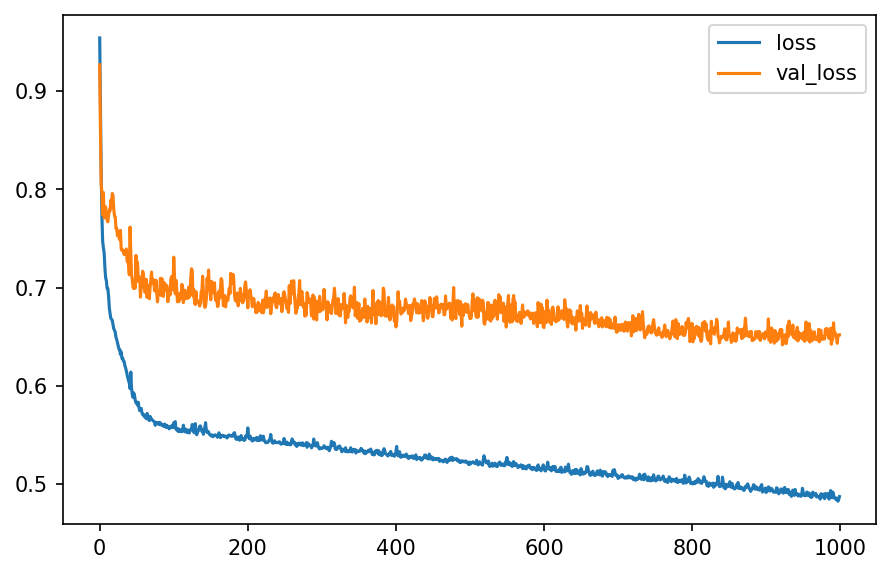

In [13]:
model = keras.models.Sequential()
#model.add(keras.layers.Flatten(input_shape=[18]))
model.add(keras.layers.Dense(10, activation = 'tanh', input_shape = (8,)))
model.add(keras.layers.Dense(10, activation='tanh'))
model.add(keras.layers.Dense(10, activation='tanh'))
model.add(keras.layers.Dense(10, activation='tanh'))
model.add(keras.layers.Dense(10, activation='tanh'))
model.add(keras.layers.Dense(10, activation='tanh'))
model.add(keras.layers.Dense(10, activation='tanh'))
model.add(keras.layers.Dense(10, activation='tanh'))
model.add(keras.layers.Dense(10, activation='tanh'))
model.add(keras.layers.Dense(1, activation='tanh'))
model.summary()

optimizer = keras.optimizers.Adam(learning_rate = 0.001, 
                                  beta_1 = 0.9, 
                                  beta_2 = 0.999, 
                                  amsgrad = False)

model.compile(loss='mean_squared_error', optimizer=optimizer)
history = model.fit(X_train, y_train, batch_size = 512, epochs = 1000, validation_split = 0.05)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])

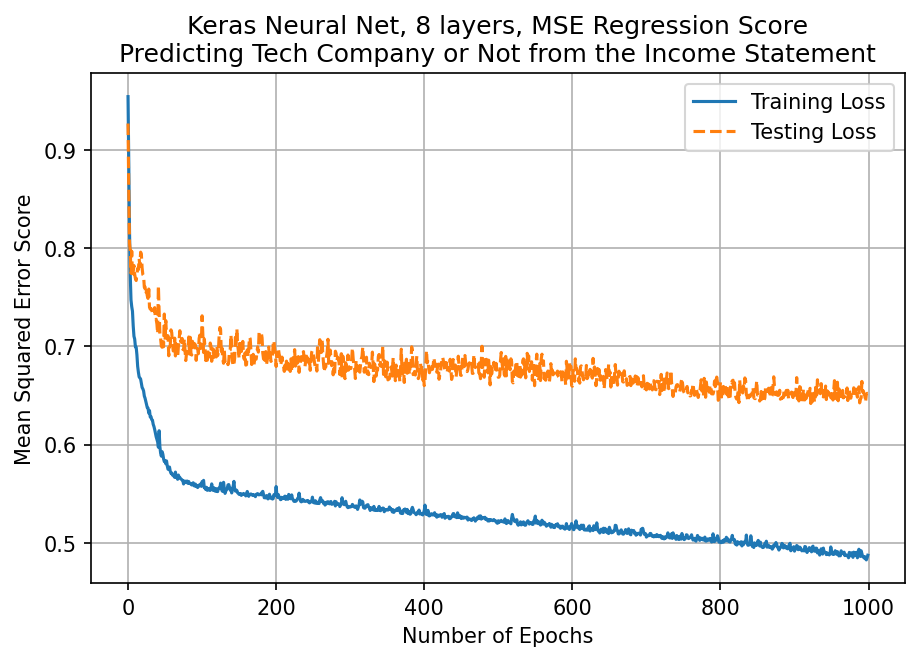

In [15]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'],'--')
plt.legend(['Training Loss','Testing Loss'])
plt.grid()
plt.ylabel('Mean Squared Error Score');
plt.xlabel('Number of Epochs');
plt.title('Keras Neural Net, 8 layers, MSE Regression Score\n'+\
          'Predicting Tech Company or Not from the Income Statement');

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 10)                90        
_________________________________________________________________
dense_28 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_29 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_30 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_31 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_32 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_33 (Dense)             (None, 10)               

5988/5988 [==============================] - 0s 10us/sample - loss: 0.5554 - val_loss: 0.6953
Epoch 61/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5512 - val_loss: 0.6910
Epoch 62/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5529 - val_loss: 0.6810
Epoch 63/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5619 - val_loss: 0.7049
Epoch 64/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5511 - val_loss: 0.7029
Epoch 65/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5468 - val_loss: 0.7052
Epoch 66/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5466 - val_loss: 0.6855
Epoch 67/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5471 - val_loss: 0.7066
Epoch 68/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.5516 - val_loss: 0.6845
Epoch 69/1000
5988/5988 [=================

5988/5988 [==============================] - 0s 10us/sample - loss: 0.5077 - val_loss: 0.6643
Epoch 211/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5036 - val_loss: 0.6606
Epoch 212/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5089 - val_loss: 0.6674
Epoch 213/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5135 - val_loss: 0.6514
Epoch 214/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5088 - val_loss: 0.6464
Epoch 215/1000
5988/5988 [==============================] - 0s 9us/sample - loss: 0.5010 - val_loss: 0.6628
Epoch 216/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5029 - val_loss: 0.6549
Epoch 217/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5090 - val_loss: 0.6412
Epoch 218/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.5135 - val_loss: 0.6978
Epoch 219/1000
5988/5988 [=========

5988/5988 [==============================] - 0s 10us/sample - loss: 0.4575 - val_loss: 0.6241
Epoch 361/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.4497 - val_loss: 0.6193
Epoch 362/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.4606 - val_loss: 0.6542
Epoch 363/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.4570 - val_loss: 0.6345
Epoch 364/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.4502 - val_loss: 0.6168
Epoch 365/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.4528 - val_loss: 0.6374
Epoch 366/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.4515 - val_loss: 0.6141
Epoch 367/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.4594 - val_loss: 0.6449
Epoch 368/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.4571 - val_loss: 0.6342
Epoch 369/1000
5988/5988 [========

5988/5988 [==============================] - 0s 10us/sample - loss: 0.4106 - val_loss: 0.6351
Epoch 511/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.4196 - val_loss: 0.6498
Epoch 512/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.4129 - val_loss: 0.6337
Epoch 513/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.4150 - val_loss: 0.6118
Epoch 514/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.4088 - val_loss: 0.6167
Epoch 515/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.4181 - val_loss: 0.6206
Epoch 516/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.4271 - val_loss: 0.6384
Epoch 517/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.4320 - val_loss: 0.6658
Epoch 518/1000
5988/5988 [==============================] - 0s 11us/sample - loss: 0.4465 - val_loss: 0.6536
Epoch 519/1000
5988/5988 [========

5988/5988 [==============================] - 0s 10us/sample - loss: 0.3865 - val_loss: 0.6307
Epoch 661/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.3839 - val_loss: 0.6235
Epoch 662/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.3803 - val_loss: 0.6530
Epoch 663/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.3902 - val_loss: 0.6352
Epoch 664/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.4001 - val_loss: 0.6917
Epoch 665/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.4031 - val_loss: 0.6635
Epoch 666/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.3977 - val_loss: 0.6107
Epoch 667/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.3941 - val_loss: 0.6493
Epoch 668/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.4039 - val_loss: 0.6793
Epoch 669/1000
5988/5988 [========

5988/5988 [==============================] - 0s 10us/sample - loss: 0.3726 - val_loss: 0.6427
Epoch 811/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.3728 - val_loss: 0.6270
Epoch 812/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.3785 - val_loss: 0.6688
Epoch 813/1000
5988/5988 [==============================] - 0s 9us/sample - loss: 0.3718 - val_loss: 0.6494
Epoch 814/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.3697 - val_loss: 0.6617
Epoch 815/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.3882 - val_loss: 0.6648
Epoch 816/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.3795 - val_loss: 0.6243
Epoch 817/1000
5988/5988 [==============================] - 0s 18us/sample - loss: 0.3692 - val_loss: 0.6404
Epoch 818/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.3639 - val_loss: 0.6656
Epoch 819/1000
5988/5988 [=========

5988/5988 [==============================] - 0s 10us/sample - loss: 0.3473 - val_loss: 0.5964
Epoch 961/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.3481 - val_loss: 0.6512
Epoch 962/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.3518 - val_loss: 0.6347
Epoch 963/1000
5988/5988 [==============================] - 0s 9us/sample - loss: 0.3499 - val_loss: 0.5916
Epoch 964/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.3538 - val_loss: 0.6433
Epoch 965/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.3509 - val_loss: 0.6501
Epoch 966/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.3439 - val_loss: 0.6407
Epoch 967/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.3504 - val_loss: 0.6476
Epoch 968/1000
5988/5988 [==============================] - 0s 10us/sample - loss: 0.3511 - val_loss: 0.6661
Epoch 969/1000
5988/5988 [=========

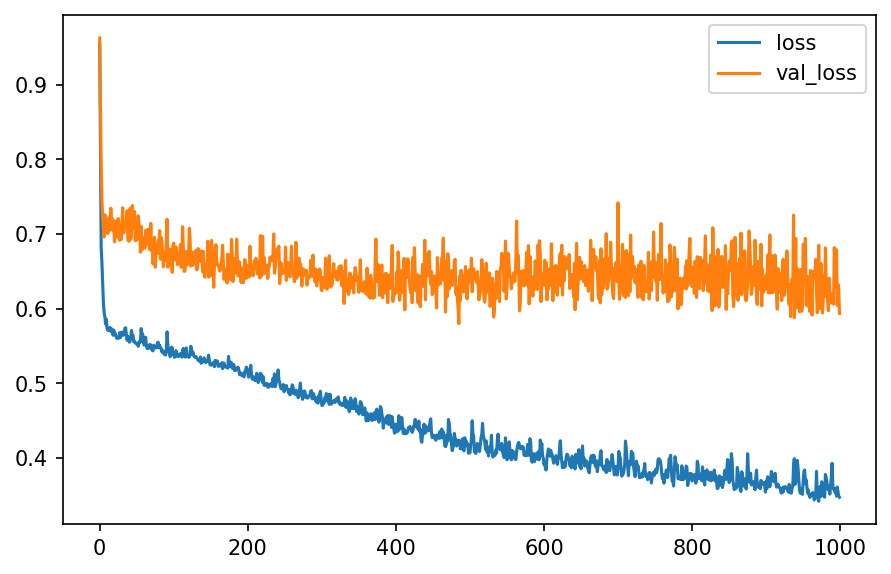

In [19]:
model = keras.models.Sequential()
#model.add(keras.layers.Flatten(input_shape=[18]))
model.add(keras.layers.Dense(10, activation = 'tanh', input_shape = (8,)))
model.add(keras.layers.Dense(10, activation='tanh'))
model.add(keras.layers.Dense(10, activation='tanh'))
model.add(keras.layers.Dense(10, activation='tanh'))
model.add(keras.layers.Dense(10, activation='tanh'))
model.add(keras.layers.Dense(10, activation='tanh'))
model.add(keras.layers.Dense(10, activation='tanh'))
model.add(keras.layers.Dense(10, activation='tanh'))
model.add(keras.layers.Dense(10, activation='tanh'))
model.add(keras.layers.Dense(1, activation='tanh'))
model.summary()

optimizer = keras.optimizers.Adam(learning_rate = 0.005, 
                                  beta_1 = 0.9, 
                                  beta_2 = 0.999, 
                                  amsgrad = False)

model.compile(loss='mean_squared_error', optimizer=optimizer)
history = model.fit(X_train, y_train, batch_size = 512, epochs = 1000, validation_split = 0.05)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])

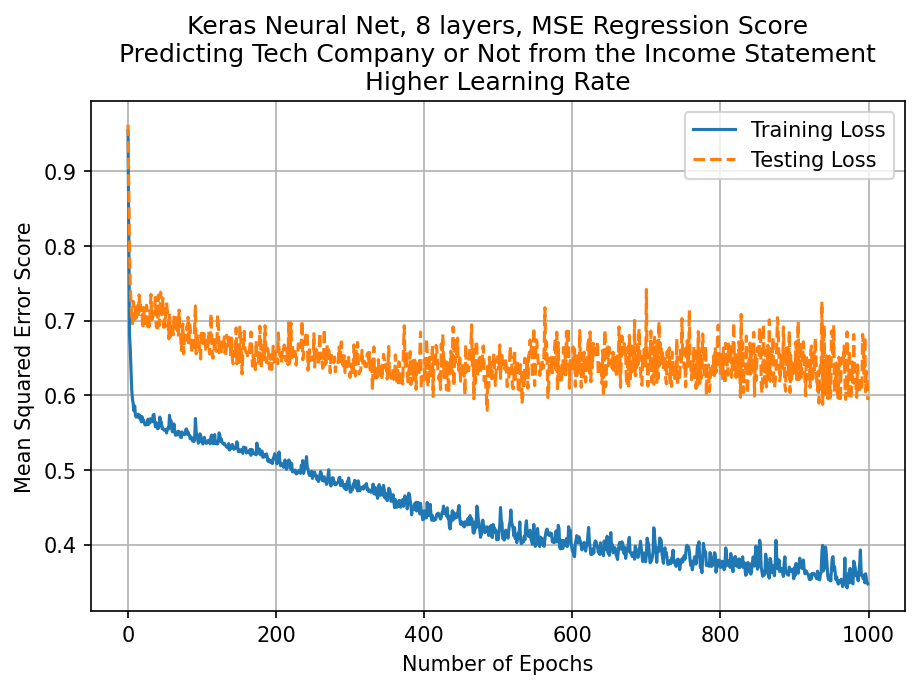

In [21]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'],'--')
plt.legend(['Training Loss','Testing Loss'])
plt.grid()
plt.ylabel('Mean Squared Error Score');
plt.xlabel('Number of Epochs');
plt.title('Keras Neural Net, 8 layers, MSE Regression Score\n'+\
          'Predicting Tech Company or Not from the Income Statement\n'+\
          'Higher Learning Rate');